In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline
import GPy
import cvxpy

plt.style.use('ggplot')

In [214]:
def gauss_gp(y, plot = False, extra_len = 1):
    """
    y: np n x 1 array of input data
    """   
    x = np.atleast_2d(np.linspace(0, y.shape[0] - 1, y.shape[0])).T
    
    # squared gaussian kernel
    kernel  = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

    # initialize gaussian process
    gp = GPy.models.GPRegression(x,y,kernel)
    
    # optimize gp
    gp.optimize()
  
    # point to predict at
    point = (x[-1] + 1).reshape(1, -1)
    
    # predict
    pred, sigma = gp.predict(point)
    
    return_frac = pred / y[-1] - 1
    
    # plotting
    if plot:
        plot_gp(x, y, gp, (point[0,0], pred[0,0]), extra_len)
    
    # return sharpe
    return return_frac[0,0], sigma

In [211]:
def plot_gp(x, y, gp, point, extra_len = 1):
    """
    x: numpy array of the domain of the gp
    y: original data
    gp: a 1d GPRegression object
    point: tuple of predicted point
    """
    domain = np.linspace(x[0], point[0] + extra_len, 200)[:, np.newaxis]
    pred, sigma = gp.predict(domain)
    plt.figure(figsize = (14,10))
    plt.plot(domain, pred, label = 'Prediction Mean', color = 'k')
    plt.scatter(x, y, label = 'Actual Values', color = 'r', marker = 'o')
    
    plt.fill_between(domain[:,0], (pred - sigma)[:,0], (pred + sigma)[:,0], alpha=.5, label = '+/- sigma')
    
    plt.xlim(0,domain[-1])
    
    plt.plot(point[0], point[1], label = 'Predicted Price', marker = '*', c = 'black', markersize = 20.)
    
    plt.legend()
    
    

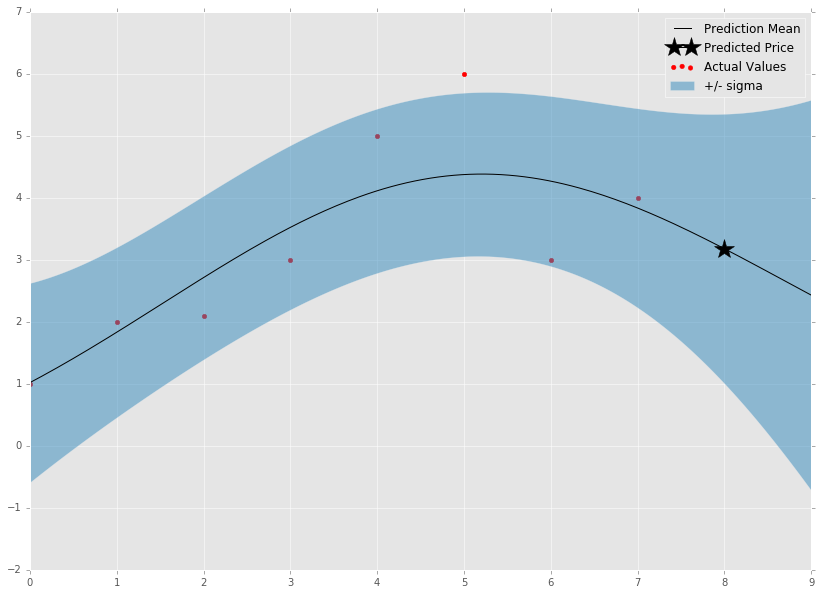

In [215]:
a = np.array([[1, 2, 2.1, 3, 5, 6,3 ,4]]).T
R, cov = gauss_gp(a, True)

In [4]:
def cov_return_sigma(X, sharpe_func):
    """
    X: n x k numpy array of stocks
    sharpe_func: function that takes an n x 1 array of input data and 
                 returns a tuple of return rate and std. deviation of 
                 that return rate
    """
    
    cov = np.cov(X)
    
    return_sigma = np.array([sharpe_func(X[i][:, np.newaxis]) for i in range(X.shape[0])])
    
    returns = return_sigma[:,0]
    sigma = return_sigma[:,1]
    
    return cov, returns, sigma
    

In [120]:
def read_stocks(dir_name, random = False, num_rand = None):
    """
    dir_name: string directory name
    
    returns: stocks as rows all concatenated to min. length
    
    Assumes stocks are csv's
    """
    stock_files = glob.glob(dir_name + '/*.csv')
    
    if random:
        ind = np.random.randint(0, len(stock_files), size = num_rand)
        stock_files = list(np.array(stock_files)[ind])
    
    labels = []
    
    X = []
    min_len = 100000
    
    for stock in stock_files:
        x = pd.read_csv(stock)['Adj Close'].as_matrix().astype(np.float64)
        if x.shape[0] >= 100:
            if x.shape[0] < min_len:
                min_len = x.shape[0]
            X.append(x)
            labels.append(stock[len(dir_name) + 1:][0:-4])
        
    for i in range(len(X)):
        X[i] = X[i][-min_len:]
        
    X = np.array(X)
    
    # lables
    return labels, X[:,0:-1], X[:,-1][:,np.newaxis]

In [110]:
def optimize_port(R, sigma, theta):
    """
    cor: Nxk correlation matrix of stocks
    returns: Nx1 return fraction matrix
    sigma: Nx1 expected standard deviation on returns
    """
    
    w = cvxpy.Variable(R.shape[0])
    
    objective = cvxpy.Minimize(-theta * R.T @ w + (1 - theta) * cvxpy.quad_form(w, sigma))
    
    ones = np.ones(R.shape[0])
    
    constraints = [w >= 0, sum(w) == 1]
    
    problem = cvxpy.Problem(objective, constraints)
    
    result = problem.solve()
    
    return (w.value)
    
    

In [222]:
labels, X, y = read_stocks('/home/nate/Courses/bigdata/bigdata_hw/final_project/stock_data2')

cov, returns, sigma = cov_return_sigma(X, gauss_gp) 

cov += 10 * np.diag(sigma)
    
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

is_pos_def(cov)

True

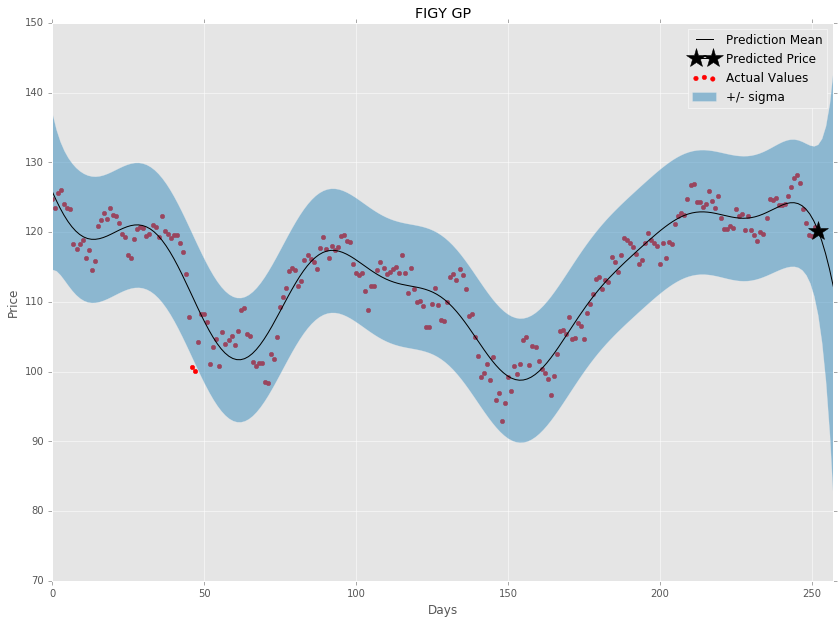

In [368]:
gauss_gp(X[0][:,np.newaxis],plot=True, extra_len=5)
plt.xlabel('Days')
plt.ylabel('Price')
plt.title("FIGY GP")

In [114]:
opt = optimize_port(returns, cov, .5)

In [115]:
print(opt.shape)

l = np.array(labels)[:,np.newaxis]

choices = l[np.where(opt>.001)]

weights = opt[opt>.001]

weights /= np.sum(weights)

print(weights, choices)

(48, 1)
[[ 0.03144221  0.00553032  0.0353734   0.13879926  0.00245592  0.01147424
   0.00977938  0.05875406  0.01936416  0.51558835  0.0772557   0.01873162
   0.00162832  0.02449255  0.0122944   0.00434967  0.00251014  0.00272269
   0.02745363]] ['FINZ' 'FL' 'FGL' 'FHY' 'FIT' 'FIVN' 'FLIC' 'FITBI' 'FLAT' 'FHCO' 'FIG'
 'FISI' 'FINL' 'FLC' 'FGEN' 'FITB' 'FIX' 'FGP' 'FHN']


In [335]:
def return_frac(w, X, y):
    """
    w: weights of stocks
    X: original data
    y: back_test data
    """
    returns = (y / X[:,-1])
    return (w.T @ returns)[0,0]

In [393]:
def find_theta(X, y, returns, cov, days, verbose = False):
    """
    
    """
    bestVal = -10000
    bestTheta = 0
    
    if verbose:
        print('Beginning Theta Optimization')

    for theta in np.linspace(0, 1, 10):
        if verbose:
            print('{:04.2f}% done'.format(float(theta * 100)))
        
        opt = optimize_port(returns, cov, theta)
        
        
        return_list = trade_period(X, days, theta)

        temp = total_return(return_list)
        if temp > bestVal:
            bestVal = temp
            bestTheta = theta    
    return bestVal, bestTheta

In [394]:
bestValm, bestTheta= find_theta(X[:,0:10],y[:,0:10],returns, cov, days = 1, verbose= True)
print(bestValm, bestTheta)

Beginning Theta Optimization
0.00% done
11.11% done
22.22% done
33.33% done
44.44% done
55.56% done
66.67% done
77.78% done
88.89% done
100.00% done
1.00357686359 0.0


In [397]:
def full_test(dir_name, num_stocks, num_tests, theta, days, verbose = False):
    """
    dir_name: directory to test on
    num_stocks: stocks per test
    num_tests: number of test iterations
    theta: pre chosen theta
    days: number of days per simulation
    verbose: print as progressing?
    """
    
    thetas = []
    returns_list = []
    cov_list = []
    for i in range(num_tests):
        if verbose:
            print('{}% complete'.format(i * 100./num_tests))
        
        labels, X, y = read_stocks(dir_name, random = True, num_rand=num_stocks)
        
        if verbose:
            print('Reading complete')
        
        cov, returns, sigma = cov_return_sigma(X, gauss_gp) 
        if verbose:
            print('GP complete')
        
        cov += 10 * np.diag(sigma)
        
        w = optimize_port(returns, cov, theta)
          
        bestVal, bestTheta = find_theta(X, y, returns, cov, days, verbose)
        
        if verbose:
            print('Optimizing Theta Complete')
        
        thetas.append((bestVal, bestTheta))
        
        simulated_returns = trade_period(X, days, theta, verbose)
        returns_list.append(total_return(simulated_returns))
        
        cov_list.append(w.T @ cov @ w)
        
        if verbose:
            print('All complete\n')
            
    if verbose:
        print('Done')
        
    return thetas, returns_list, cov_list

In [398]:
thetas, returns_list, cov_list = full_test('/home/nate/Courses/bigdata/bigdata_hw/final_project/DAILY', num_stocks = 10, num_tests = 10,theta= 1., days = 10, verbose=True)   

0.0% complete
Reading complete
GP complete
Begin theta
Beginning Theta Optimization
0.00% done
11.11% done
22.22% done
33.33% done
44.44% done
55.56% done
66.67% done
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [256]:
print(thetas)

[(0.0, 1.0), (0.012545241640306855, 0.88888888888888884), (0.00097371576074245373, 0.0), (0.0142180094786728, 1.0), (0.0037189924499246665, 0.88888888888888884), (0.0079207920792079278, 1.0), (0.039291051065940996, 1.0), (-0.0015844574065276627, 0.0), (0.030064423765211234, 1.0), (0.062874251497005984, 1.0)]


In [352]:
def trade_period(X, days, theta, verbose = False):
    return_list = []
    
    for day in range(days):
        if verbose:
            print('{}% complete'.format(day * 100./days))
        
        Xt = X[:,:-day-1]
        yt = Xt[:,-1]
        Xt = Xt[:,:-1]
        
        cov, returns, sigma = cov_return_sigma(Xt, gauss_gp) 
        
        cov += 10 * np.diag(sigma)
        
        w = optimize_port(returns, cov, theta)
        
        return_list.append(return_frac(w, Xt, yt))
        
    if verbose:
        print('Done')
        
    return return_list
        
    
def total_return(return_list):
    return np.prod(np.array(return_list))

In [355]:
return_list = trade_period(X, 100, .1, True)
print(total_return(return_list))

0.0% complete
1.0% complete
2.0% complete
3.0% complete
4.0% complete
5.0% complete
6.0% complete
7.0% complete
8.0% complete
9.0% complete
10.0% complete
11.0% complete
12.0% complete
13.0% complete
14.0% complete
15.0% complete
16.0% complete
17.0% complete
18.0% complete
19.0% complete
20.0% complete
21.0% complete
22.0% complete
23.0% complete
24.0% complete
25.0% complete
26.0% complete
27.0% complete
28.0% complete
29.0% complete
30.0% complete
31.0% complete
32.0% complete
33.0% complete
34.0% complete
35.0% complete
36.0% complete
37.0% complete
38.0% complete
39.0% complete
40.0% complete
41.0% complete
42.0% complete
43.0% complete
44.0% complete
45.0% complete
46.0% complete
47.0% complete
48.0% complete
49.0% complete
50.0% complete
51.0% complete
52.0% complete
53.0% complete
54.0% complete
55.0% complete
56.0% complete
57.0% complete
58.0% complete
59.0% complete
60.0% complete
61.0% complete
62.0% complete
63.0% complete
64.0% complete
65.0% complete
66.0% complete
67.0%

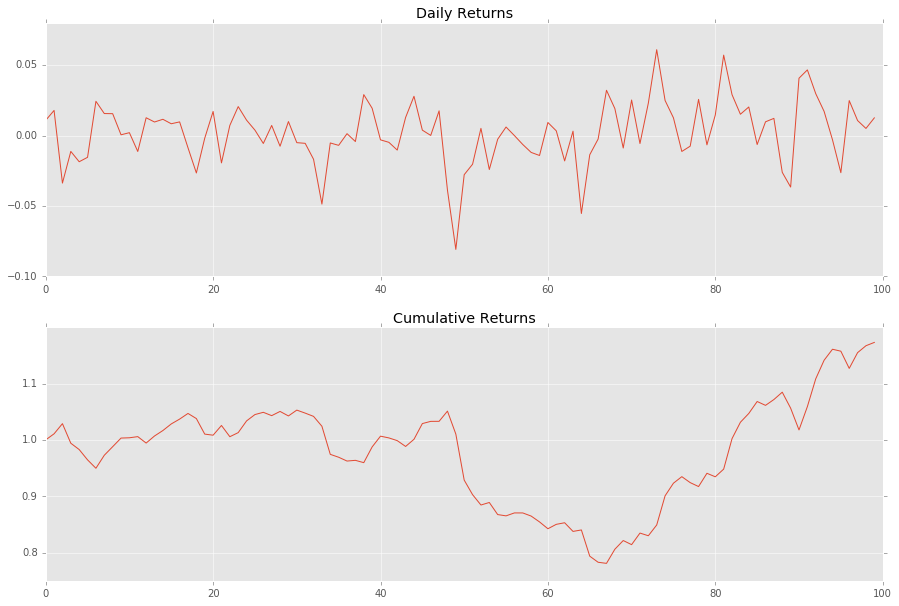

In [367]:
plt.figure(figsize = (15,10))

plt.subplot(211)
plt.plot(np.array(return_list)-1)
plt.title('Daily Returns')

plt.subplot(212)
r = np.array(return_list)
cum_returns = [np.prod(r[:i]) for i in range(len(return_list))]
plt.plot(cum_returns)
plt.title('Cumulative Returns')

In [406]:
def markowitz_frontier(X):
    cov, returns, sigma = cov_return_sigma(X, gauss_gp)
    plt.scatter(sigma, returns)

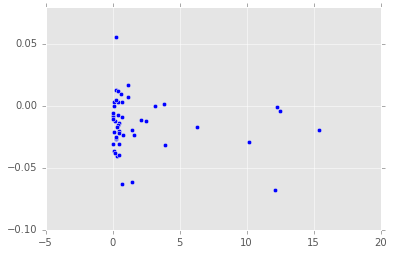

In [407]:
markowitz_frontier(X)

In [408]:
X.shape

(48, 252)